In [1]:
import numpy as np 
import pandas as pd 
import os
import shutil
from pathlib import Path
from PIL import Image
import cv2
from sklearn.model_selection import StratifiedGroupKFold
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
INPUT_DIR = '../input/'
DATA_FOLDER = 'uw-madison-gi-tract-image-segmentation/'
IMG_DIR = INPUT_DIR + DATA_FOLDER
OUT_DIR = '../working/'
OUT_IMG_DIR = OUT_DIR + 'images/'
OUT_MASKS_DIR = OUT_DIR + 'masks/'
TMP_IMG_DIR = '/tmp/images/'
TMP_MASKS_DIR = '/tmp/masks/'
# os.makedirs(OUT_IMG_DIR, exist_ok=True)
# os.makedirs(OUT_MASKS_DIR, exist_ok=True)

FOLDS = 5
SEED = 42
CHANNELS = 3
USE_DEPTH = True
STRIDE = 2
IMG_SIZE = [320, 384]
DEBUG = False

In [3]:
train_df = pd.read_csv(IMG_DIR + 'train.csv')
if DEBUG:
    train_df = train_df.head(999)
CLASSES = train_df['class'].unique()
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
def merge_ids(df):
    df['segmentation'] = df['segmentation'].fillna("")
    df['rle_len'] = df['segmentation'].map(len)
    
    df2 = df.groupby(["id"])["segmentation"].agg(list).to_frame().reset_index()
    df2 = df2.merge(df.groupby(["id"])["rle_len"].agg(sum).to_frame().reset_index())
    
    df = df.drop(columns=["class", "segmentation", "rle_len"])
    df = df.groupby(["id"]).head(1).reset_index(drop=True)
    df = df.merge(df2, on=["id"])
    
    df["empty"] = (df.rle_len==0)
    
    return df

In [5]:
def add_metadata_from_id(df):
    df[['case', 'day', 'slice']] = df['id'].str.split('_', n=2, expand=True)
    df['case'] = df['case'].str.replace('case', '').astype(int)
    df['day'] = df['day'].str.replace('day', '').astype(int)
    df['slice'] = df['slice'].str.replace('slice_', '').astype(int)
    
    return df

In [6]:
train_df = merge_ids(train_df)
train_df[~train_df["empty"]].head()

,id,segmentation,rle_len,empty
64,case123_day20_slice_0065,"[, , 28094 3 28358 7 28623 9 28889 9 29155 9 2...",149,False
65,case123_day20_slice_0066,"[, , 27561 8 27825 11 28090 13 28355 14 28620 ...",204,False
66,case123_day20_slice_0067,"[, , 15323 4 15587 8 15852 10 16117 11 16383 1...",688,False
67,case123_day20_slice_0068,"[, , 14792 5 15056 9 15321 11 15587 11 15852 1...",724,False
68,case123_day20_slice_0069,"[, , 14526 6 14789 12 15054 14 15319 16 15584 ...",744,False


In [7]:
train_df = add_metadata_from_id(train_df)
train_df.head()

,id,segmentation,rle_len,empty,case,day,slice
0,case123_day20_slice_0001,"[, , ]",0,True,123,20,1
1,case123_day20_slice_0002,"[, , ]",0,True,123,20,2
2,case123_day20_slice_0003,"[, , ]",0,True,123,20,3
3,case123_day20_slice_0004,"[, , ]",0,True,123,20,4
4,case123_day20_slice_0005,"[, , ]",0,True,123,20,5


In [8]:
len(train_df)

38496

In [9]:
def extract_metadata_from_path(path_df):
    path_df[["parent", "case_day", "scans", "file_name"]] = path_df["image_path"].str.rsplit("/", n=3, expand=True)

    path_df[["case", "day"]] = path_df["case_day"].str.split("_", expand=True)
    path_df["case"] = path_df["case"].str.replace("case", "")
    path_df["day"] = path_df["day"].str.replace("day", "")

    path_df[["slice", "width", "height", "spacing", "spacing_"]] = (
        path_df["file_name"].str.replace("slice_", "").str.replace(".png", "").str.split("_", expand=True)
    )
    path_df = path_df.drop(columns=["parent", "case_day", "scans", "file_name", "spacing_"])

    numeric_cols = ["case", "day", "slice", "width", "height", "spacing"]
    path_df[numeric_cols] = path_df[numeric_cols].apply(pd.to_numeric)

    return path_df

def add_image_path(df, data_dir, stage="train"):
    image_paths = [str(path) for path in Path(data_dir + stage).rglob("*.png")]
    path_df = pd.DataFrame(image_paths, columns=["image_path"])

    path_df = extract_metadata_from_path(path_df)

    df = df.merge(path_df, on=["case", "day", "slice"])

    return df

In [10]:
train_df = add_image_path(train_df, IMG_DIR)
train_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


,id,segmentation,rle_len,empty,case,day,slice,image_path,width,height,spacing
0,case123_day20_slice_0001,"[, , ]",0,True,123,20,1,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5
1,case123_day20_slice_0002,"[, , ]",0,True,123,20,2,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5
2,case123_day20_slice_0003,"[, , ]",0,True,123,20,3,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5
3,case123_day20_slice_0004,"[, , ]",0,True,123,20,4,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5
4,case123_day20_slice_0005,"[, , ]",0,True,123,20,5,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.5


In [11]:
print("Width Values: ", train_df.width.unique())
print("Height Values: ", train_df.height.unique())

Width Values:  [266 360 234 276]
Height Values:  [266 310 234 276]


In [12]:
CLASSES

array(['large_bowel', 'small_bowel', 'stomach'], dtype=object)

In [13]:
def create_folds(df, n_splits, random_seed):
    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["empty"], groups=df["case"])):
        df.loc[val_idx, "fold"] = fold

    return df

In [14]:
train_df = create_folds(train_df, FOLDS, SEED)

if DEBUG:
    print(f"{len(train_df)}")
    display(train_df.head())

In [15]:
def add_mask_path(df):
    df["mask_path"] = TMP_MASKS_DIR + df['id'] + '.npy'
    return df

In [16]:
train_df = add_mask_path(train_df)

if DEBUG:
    print(f"{len(train_df)}")
    display(train_df.head())

In [17]:
def add_depth_images(df, channels, stride):
    for i in range(channels):
        df[f"image_path_{i:02}"] = df.groupby(["case", "day"])["image_path"].shift(-i * stride).fillna(method="ffill")
    
    image_path_columns = [f"image_path_{i:02d}" for i in range(channels)]
    df["image_paths"] = df[image_path_columns].values.tolist()
    df = df.drop(columns=image_path_columns)
    
    return df

In [18]:
if USE_DEPTH:    
    train_df = add_depth_images(train_df, CHANNELS, STRIDE)

    if DEBUG:
        print(f"{len(train_df)}")
        display(train_df.head())

In [19]:
train_df.describe()

,rle_len,case,day,slice,width,height,spacing,fold
count,38496.000000,38496.000000,38496.000000,38496.000000,38496.000000,38496.000000,38496.000000,38496.000000
mean,551.262261,84.812968,13.354946,71.502494,293.618454,279.029925,1.504052,1.862843
std,747.853232,46.487527,10.397455,41.492726,42.688415,20.051109,0.022592,1.433895
min,0.000000,2.000000,0.000000,1.000000,234.000000,234.000000,1.500000,0.000000
25%,0.000000,42.000000,0.000000,36.000000,266.000000,266.000000,1.500000,1.000000
50%,0.000000,85.000000,16.000000,71.000000,266.000000,266.000000,1.500000,2.000000
75%,1145.000000,129.000000,21.000000,107.000000,360.000000,310.000000,1.500000,3.000000
max,3510.000000,156.000000,39.000000,144.000000,360.000000,310.000000,1.630000,4.000000


In [20]:
def load_img(path, size=IMG_SIZE, tile:bool = True):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = np.pad(img, [pady, padx])
        img = img.reshape((*resize))
    if tile:    
        img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
        img = img.astype('float32') # original is uint16
        mx = np.max(img)
        if mx:
            img/=mx # scale image to [0, 1]
    return img

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    """
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# def load_mask(path, masks_rle, original_size,target_size=IMG_SIZE):
def load_mask(row,target_size=IMG_SIZE):
    shape = (row.height, row.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)

    for i, rle in enumerate(row.segmentation):
        if rle:
            mask[..., i] = rle_decode(rle, shape[:2])

    mask = mask * 255
    
    shape0 = np.array(mask.shape[:2])
    resize = np.array(target_size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        mask = np.pad(mask, [pady, padx, [0,0]])
        mask = mask.reshape((*resize, 3))
    return mask

def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = CLASSES
        plt.legend(handles,labels)
#     plt.axis('off')
    
def load_imgs(img_paths, size=IMG_SIZE):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        img = load_img(img_path, size=size, tile = False)
        imgs[..., i]+=img
    return imgs

### **Show Images and Masks**

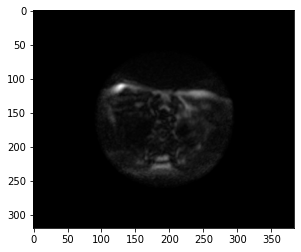

In [21]:
img = load_img(train_df.image_path.iloc[0])
plt.imshow(img)

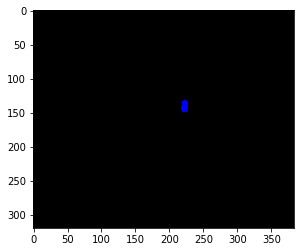

In [22]:
mask = load_mask(train_df[~train_df['empty']].iloc[0])
plt.imshow(mask)

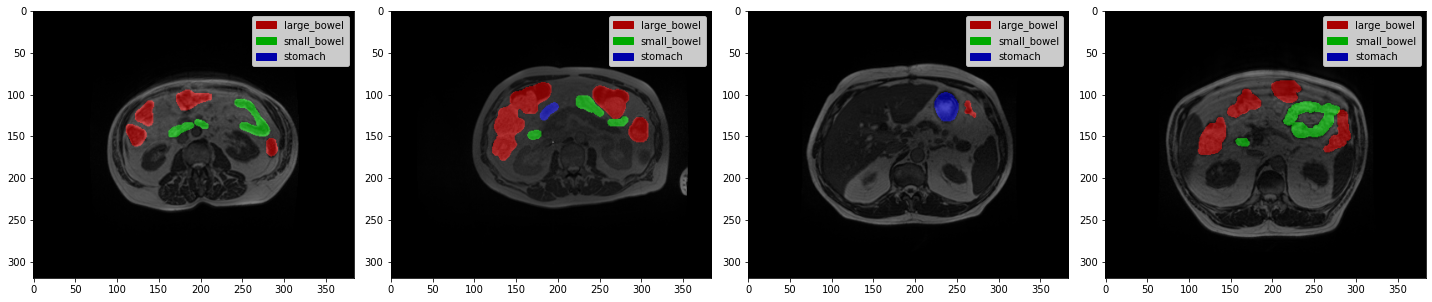

In [23]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(train_df[~train_df['empty']].sample(frac=1.0)['id'].unique()[:row*col]):
    idf = train_df[train_df['id']==id_]
    img = load_img(idf.image_path.iloc[0])
#     mask = load_mask(idf.mask_path.iloc[0], idf.segmentation.iloc[0], (idf.height.iloc[0], idf.width.iloc[0]))
    mask = load_mask(idf.iloc[0])
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

### **Show 2.5D Images**

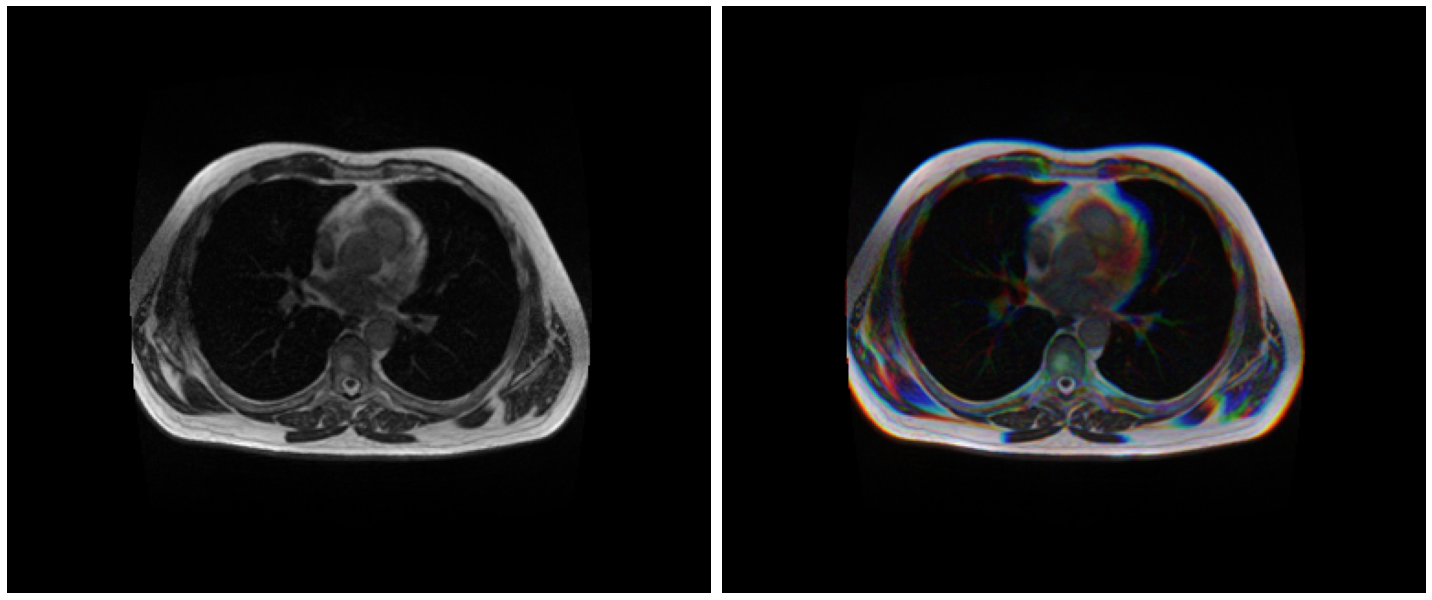

In [24]:
idx = 40

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
img = load_img(train_df.image_path[idx]).astype('float32')
#     img/=img.max()
plt.imshow(img)
plt.axis('off')

if USE_DEPTH:  
    plt.subplot(1, 2, 2)
    imgs = load_imgs(train_df.image_paths[idx]).astype('float32')
    imgs/=imgs.max(axis=(0,1))
    plt.imshow(imgs)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
def save_array(file_path, array):
    file_path = Path(file_path)
    np.save(file_path, array)

### **Save images and masks**

In [26]:
!mkdir -p $TMP_IMG_DIR && mkdir -p $TMP_MASKS_DIR

In [27]:
for row in tqdm(train_df.itertuples(), total=len(train_df)):
    mask = load_mask(row)
    if USE_DEPTH:
        img = load_imgs(row.image_paths)
    else:
        img = load_img(row.image_path)
    save_array(row.mask_path, mask)
    save_array(TMP_IMG_DIR + row.id + '.npy', img)

  0%|          | 0/38496 [00:00<?, ?it/s]

### **Check Masks and Images**

In [28]:
len(np.unique(os.listdir(TMP_MASKS_DIR)))

38496

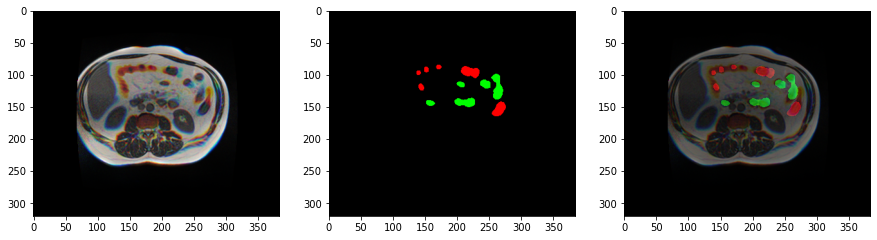

In [29]:
plt.figure(figsize=(15, 5))

imgs = np.load(f'{TMP_IMG_DIR}case123_day22_slice_0101.npy').astype('float32')
imgs/=imgs.max(axis=(0,1))

plt.subplot(1, 3, 1)
plt.imshow(imgs)

msk = np.load(f'{TMP_MASKS_DIR}case123_day22_slice_0101.npy').astype('float32')
msk/=255.0

plt.subplot(1, 3, 2)
plt.imshow(msk)


plt.subplot(1, 3, 3)
plt.imshow(imgs)
plt.imshow(msk, alpha=0.5)



In [30]:
shutil.make_archive(OUT_IMG_DIR,
                    'zip',
                   '/tmp',
                   'images')

'/kaggle/working/images.zip'

In [31]:
shutil.make_archive(OUT_MASKS_DIR,
                    'zip',
                   '/tmp',
                   'masks')

'/kaggle/working/masks.zip'

In [32]:
train_df['image_path'] = INPUT_DIR + 'uw-madison-gi-tract-image-segmentation-preprocessed/' + train_df['id'] + '.npy'
train_df["mask_path"] = train_df["mask_path"].str.replace('/tmp/', INPUT_DIR+"uw-madison-gi-tract-image-segmentation-preprocessed/")

In [33]:
# !rm /kaggle/working/images -rf
# !rm /kaggle/working/masks -rf

In [34]:
train_df.to_csv("../working/train_preprocessed.csv", index=False)